In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('../../utils')
from split_dataset import split_dataframe_by_keys
from dataset_loader import TidySequentialDataCSVLoader
%matplotlib inline

## Load the vitals and demographics

In [2]:
data_dir = '/cluster/tufts/hugheslab/datasets/MIMIC-IV/'
suffix = '_first_24_hours'
ts_csv = os.path.join(data_dir, 'features_per_tstep%s_los_prediction.csv.gz'%suffix)
dem_csv = os.path.join(data_dir, 'demographics%s_los_prediction.csv.gz'%suffix)
outcomes_csv = os.path.join(data_dir, 'outcomes_per_seq%s_los_prediction.csv'%suffix)


ts_df = pd.read_csv(ts_csv)
dem_df = pd.read_csv(dem_csv)
outcomes_df = pd.read_csv(outcomes_csv)

In [3]:
dem_df.head()

,subject_id,hadm_id,stay_id,Age,is_gender_male,is_gender_unknown,admission_timestamp
0,12466550,23998182,30000153,61,1,0,2174-09-29 12:09:00
1,13180007,27543152,30000213,64,1,0,2162-06-21 05:38:00
2,18421337,22413411,30000484,91,1,0,2136-01-14 17:23:32
3,12207593,22795209,30000646,43,1,0,2194-04-29 01:39:22
4,12980335,23552849,30001148,68,1,0,2156-08-30 11:10:59


In [4]:
outcomes_df.head()

,subject_id,hadm_id,stay_id,in_icu_mortality,length_of_stay_in_hours,admission_timestamp
0,12466550,23998182,30000153,0,39.286111,2174-09-29 12:09:00
1,13180007,27543152,30000213,0,39.246667,2162-06-21 05:38:00
2,18421337,22413411,30000484,0,59.493333,2136-01-14 17:23:32
3,12207593,22795209,30000646,0,112.740556,2194-04-29 01:39:22
4,12980335,23552849,30001148,0,27.243056,2156-08-30 11:10:59


## Remove stays less than 30 hours

In [3]:
min_stay_hrs = 30
keep_inds = outcomes_df['length_of_stay_in_hours']>=min_stay_hrs
outcomes_df = outcomes_df.loc[keep_inds, :].copy().reset_index(drop=True)
ts_df = ts_df.loc[ts_df['stay_id'].isin(outcomes_df['stay_id']), :].reset_index(drop=True)
dem_df = dem_df.loc[ts_df['stay_id'].isin(outcomes_df['stay_id']), :].reset_index(drop=True)


stay_lengths = outcomes_df['length_of_stay_in_hours'].values
n_stays = len(outcomes_df['stay_id'].unique())
n_patients = len(outcomes_df['subject_id'].unique())
n_deaths = outcomes_df['in_icu_mortality'].sum()

print('Total stays : %d'%n_stays)
print('Total patients : %d'%n_patients)
print('Frac of stays resulting in death : %.3f'%(n_deaths/n_stays))
print('Frac of patients who die : %.3f'%(n_deaths/n_patients))

for min_los in [3, 7, 11]:
    inds = stay_lengths>=min_los*24
    frac_above_min_los = len(stay_lengths[inds])/n_stays
    print('Frac stays > %d days : %.3f'%(min_los, frac_above_min_los))

Total stays : 52354
Total patients : 38939
Frac of stays resulting in death : 0.081
Frac of patients who die : 0.109
Frac stays > 3 days : 0.466
Frac stays > 7 days : 0.162
Frac stays > 11 days : 0.083


## Plot the LOS distribution

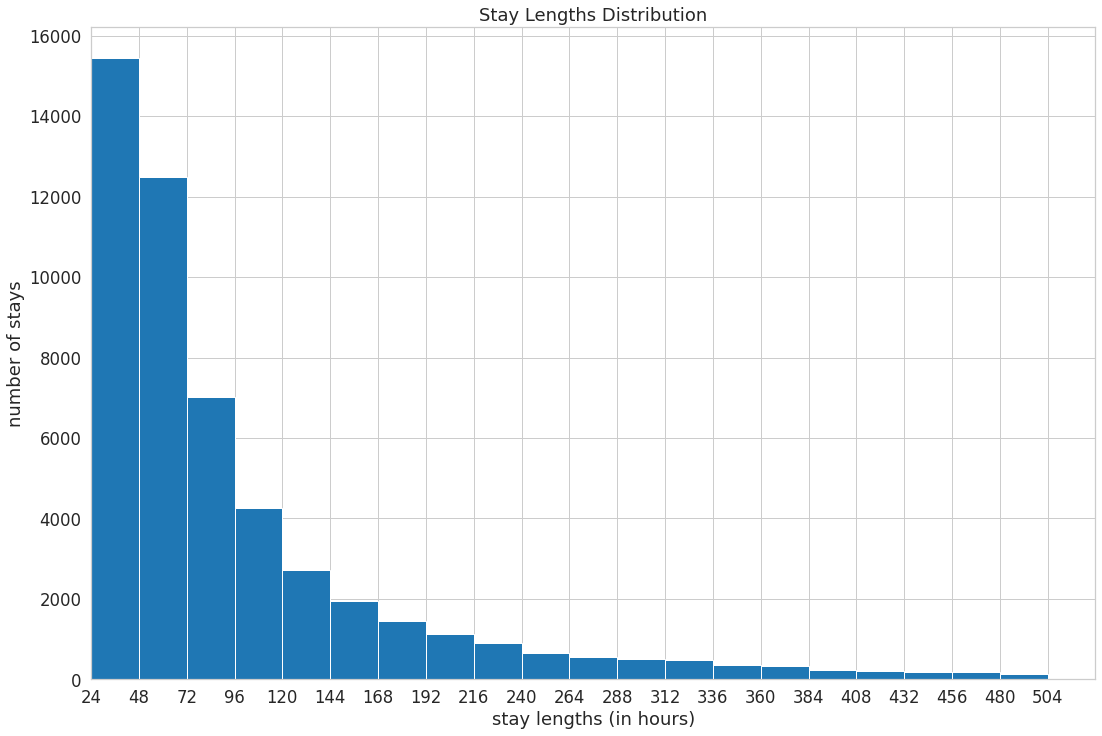

In [5]:
max_los = outcomes_df['length_of_stay_in_hours'].max()
min_t = 24
max_t = 504
step=24
bins = np.arange(24, max_t+1, step)
# bins=np.insert(bins, len(bins), max_los)

f, axs = plt.subplots(1, 1, figsize=(18, 12))
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.5)
x = outcomes_df['length_of_stay_in_hours'].values
axs.hist(x, bins=bins, 
        )
axs.set_xlabel('stay lengths (in hours)')
axs.set_ylabel('number of stays')
axs.set_xlim([min_t, max_t+step])
# bins[-1]=max_t
axs.set_xticks(bins)
axs.set_title('Stay Lengths Distribution')
plt.show()

## Get the range of measurements of all features

In [6]:
ts_feature_cols = ['Heart Rate', 
                    'Respiratory Rate', 
                    'O2 saturation pulseoxymetry',
       'Non Invasive Blood Pressure systolic',
       'Non Invasive Blood Pressure diastolic',
        'Temperature Fahrenheit',
        'Height (cm)',
       'Respiratory Rate (Total)', 
       'Potassium (serum)',
       'Sodium (serum)', 
        'Chloride (serum)', 
        'Hematocrit (serum)',
       'Hemoglobin', 
        'Creatinine (serum)', 
        'Glucose (serum)', 
        'Magnesium', 
       'Phosphorous', 
        'Platelet Count', 
        'Glucose (whole blood)',
        'Daily Weight', 
        'Absolute Neutrophil Count',
        'Prothrombin time',
        'Fibrinogen',
        'PH (Arterial)',
        'PH (Venous)',
        'HCO3 (serum)',
        'Arterial O2 pressure',
        'Arterial CO2 Pressure',
        'Lactic Acid',
        'Albumin',
        'Calcium non-ionized',
        'C Reactive Protein (CRP)',
        'ALT',
        'AST',
        'Direct Bilirubin', 
        'Total Bilirubin',
        'Troponin-T',
        'Venous CO2 Pressure']

dem_cols = ['Age', 'is_gender_male', 'is_gender_unknown']
id_col = ['stay_id']
id_cols = ['subject_id', 'hadm_id', 'stay_id']

feature_cols = ts_feature_cols+dem_cols
features_df = pd.merge(ts_df, dem_df, on=id_cols, how='left')

In [7]:
id_col = ['stay_id']
time_cols = ['hours_from_admission', 'timestamp']

feats_summary_df = pd.DataFrame()
for lab in feature_cols:
    curr_lab_series = features_df[lab]
#     feats_summary_df.loc[lab, 'min'] = curr_lab_series.min()
#     feats_summary_df.loc[lab, 'max'] = curr_lab_series.max()
    feats_summary_df.loc[lab, '10%'] = np.nanpercentile(curr_lab_series, 10)
    feats_summary_df.loc[lab, '90%'] = np.nanpercentile(curr_lab_series, 90)
    feats_summary_df.loc[lab, 'median'] = curr_lab_series.median()


lab_counts_per_stay_df = features_df.groupby(id_col).count()
labs_missing_rate_entire_stay_dict = dict()
for lab in feature_cols:
    labs_missing_rate_entire_stay_dict[lab] = ((lab_counts_per_stay_df[lab]==0).sum())/lab_counts_per_stay_df.shape[0]
labs_missing_rate_entire_stay_series = pd.Series(labs_missing_rate_entire_stay_dict)

feats_summary_df.loc[:,'missing_rate'] = labs_missing_rate_entire_stay_series
feats_summary_df = feats_summary_df[['10%', 'median', '90%', 'missing_rate']]
feats_summary_df.to_csv('ts_feats_summary.csv')
feats_summary_df

,10%,median,90%,missing_rate
Heart Rate,63.000000,84.000000,110.000000,0.001337
Respiratory Rate,13.000000,19.000000,27.000000,0.002770
O2 saturation pulseoxymetry,93.000000,97.000000,100.000000,0.001509
Non Invasive Blood Pressure systolic,92.000000,115.000000,148.000000,0.103163
Non Invasive Blood Pressure diastolic,46.000000,63.000000,85.000000,0.103297
Temperature Fahrenheit,36.277778,36.833333,37.722222,0.073481
Height (cm),155.000000,170.000000,183.000000,0.982542
Respiratory Rate (Total),14.000000,18.000000,27.000000,0.548134
Potassium (serum),3.400000,4.100000,5.100000,0.013199
Sodium (serum),132.000000,139.000000,144.000000,0.012606


## Split in train/valid/test

In [8]:
random_state=41
x_train_df, x_test_df = split_dataframe_by_keys(
    features_df, cols_to_group=id_cols, size=0.2, random_state=random_state)

x_train_df, x_valid_df = split_dataframe_by_keys(
        x_train_df, cols_to_group=id_cols, size=0.2, random_state=random_state) 


y_train_df, y_test_df = split_dataframe_by_keys(
    outcomes_df, cols_to_group=id_cols, size=0.2, random_state=random_state)

y_train_df, y_valid_df = split_dataframe_by_keys(
        y_train_df, cols_to_group=id_cols, size=0.2, random_state=random_state) 


In [12]:
y_train_df

,subject_id,hadm_id,stay_id,in_icu_mortality,length_of_stay_in_hours,admission_timestamp
0,12466550,23998182,30000153,0,39.286111,2174-09-29 12:09:00
1,13180007,27543152,30000213,0,39.246667,2162-06-21 05:38:00
3,12207593,22795209,30000646,0,112.740556,2194-04-29 01:39:22
4,12168737,29283664,30001336,0,66.682222,2186-03-20 00:44:48
6,17461994,29537385,30001471,0,81.092500,2189-05-02 06:57:00
...,...,...,...,...,...,...
52348,19046950,24352151,39998622,0,215.655833,2135-02-11 18:13:55
52349,15669140,29818488,39999172,0,50.418611,2185-02-17 15:01:00
52350,13651601,22584645,39999230,0,211.378333,2147-08-31 22:31:28
52351,15498623,27161460,39999384,0,30.618333,2158-05-24 19:50:01


## Get the train valid test set stats and save data

In [9]:
for split, y_df, x_df in [('train', y_train_df, x_train_df),
                   ('valid', y_valid_df, x_valid_df),
                   ('test', y_test_df, x_test_df)]:

    stay_lengths = y_df['length_of_stay_in_hours'].values
    n_stays = len(y_df['stay_id'].unique())
    n_patients = len(y_df['subject_id'].unique())
    n_deaths = y_df['in_icu_mortality'].sum()

    print('Total stays : %d'%n_stays)
    print('Total patients : %d'%n_patients)
    print('Frac of stays resulting in death : %.3f'%(n_deaths/n_stays))
    print('Frac of patients who die : %.3f'%(n_deaths/n_patients))
    
    
    save_dir = '/cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/'
    for min_los in [3, 7, 11]:
        inds = stay_lengths>=min_los*24
        frac_above_min_los = len(stay_lengths[inds])/n_stays
        print('Frac stays > %d days in %s : %.3f'%(min_los, split, frac_above_min_los))
        y_df['los_geq_%s_days'%min_los] = (stay_lengths>=min_los*24)*1
    
    
#     x_df.to_csv(os.path.join(save_dir, 'x_%s.csv'%split))   
#     y_df.to_csv(os.path.join(save_dir, 'y_%s.csv'%split))  

Total stays : 33506
Total patients : 27084
Frac of stays resulting in death : 0.081
Frac of patients who die : 0.100
Frac stays > 3 days in train : 0.467
Frac stays > 7 days in train : 0.161
Frac stays > 11 days in train : 0.082
Total stays : 8377
Total patients : 7821
Frac of stays resulting in death : 0.080
Frac of patients who die : 0.086
Frac stays > 3 days in valid : 0.456
Frac stays > 7 days in valid : 0.160
Frac stays > 11 days in valid : 0.085
Total stays : 10471
Total patients : 9673
Frac of stays resulting in death : 0.084
Frac of patients who die : 0.090
Frac stays > 3 days in test : 0.472
Frac stays > 7 days in test : 0.166
Frac stays > 11 days in test : 0.085


## Save the fully supervised train/valid/test splits as numpy arrays for binary classification

In [17]:
for min_los in [3, 7, 11]:
    ## Convert from dataframe to numpy array of NxTxD
    train_vitals = TidySequentialDataCSVLoader(
        x_csv_path=x_train_df,
        y_csv_path=y_train_df,
        x_col_names=feature_cols,
        idx_col_names=id_cols,
        y_col_name="los_geq_%s_days"%min_los,
        y_label_type='per_sequence'
    )

    valid_vitals = TidySequentialDataCSVLoader(
        x_csv_path=x_valid_df,
        y_csv_path=y_valid_df,
        x_col_names=feature_cols,
        idx_col_names=id_cols,
        y_col_name="los_geq_%s_days"%min_los,
        y_label_type='per_sequence'
    )

    test_vitals = TidySequentialDataCSVLoader(
        x_csv_path=x_test_df,
        y_csv_path=y_test_df,
        x_col_names=feature_cols,
        idx_col_names=id_cols,
        y_col_name="los_geq_%s_days"%min_los,
        y_label_type='per_sequence'
    )

    train_x_NTD, y_train = train_vitals.get_batch_data(batch_id=0)
    valid_x_NTD, y_valid = valid_vitals.get_batch_data(batch_id=0)
    test_x_NTD, y_test = test_vitals.get_batch_data(batch_id=0)

    N_tr = len(train_x_NTD)
    N_va = len(valid_x_NTD)
    N_te = len(test_x_NTD)

    print('positive label fraction in train : %.3f'%(y_train.sum()/len(y_train)))
    print('positive label fraction in valid : %.3f'%(y_valid.sum()/len(y_valid)))
    print('positive label fraction in test : %.3f'%(y_test.sum()/len(y_test)))
    
    ## save the data
    
    curr_save_dir = os.path.join(save_dir, 'los_geq_%s_days_prediction'%min_los)
    # Check whether the specified path exists or not
    isExist = os.path.exists(curr_save_dir)

    if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(curr_save_dir)

    # save the data to the respective folder
    print('Saving data to %s'%curr_save_dir)
    np.save(os.path.join(curr_save_dir, 'X_train.npy'), train_x_NTD)
    np.save(os.path.join(curr_save_dir, 'y_train.npy'), y_train)
    print('Done saving train..')
    np.save(os.path.join(curr_save_dir, 'X_valid.npy'), valid_x_NTD)
    np.save(os.path.join(curr_save_dir, 'y_valid.npy'), y_valid)
    print('Done saving valid..')
    np.save(os.path.join(curr_save_dir, 'X_test.npy'), test_x_NTD)
    np.save(os.path.join(curr_save_dir, 'y_test.npy'), y_test)
    print('Done saving test..')


positive label fraction in train : 0.467
positive label fraction in valid : 0.456
positive label fraction in test : 0.472
Saving data to /cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/los_geq_3_days_prediction
Done saving train..
Done saving valid..
Done saving test..
positive label fraction in train : 0.161
positive label fraction in valid : 0.160
positive label fraction in test : 0.166
Saving data to /cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/los_geq_7_days_prediction
Done saving train..
Done saving valid..
Done saving test..
positive label fraction in train : 0.082
positive label fraction in valid : 0.085
positive label fraction in test : 0.085
Saving data to /cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/los_geq_11_days_prediction
Done saving train..
Done saving valid..
Done saving test..


## Save binary classification data based on % of labeled sequences

In [13]:
state_id = 41

for min_los in [3, 7, 11]:
    ## Convert from dataframe to numpy array of NxTxD
    train_vitals = TidySequentialDataCSVLoader(
        x_csv_path=x_train_df,
        y_csv_path=y_train_df,
        x_col_names=feature_cols,
        idx_col_names=id_cols,
        y_col_name="los_geq_%s_days"%min_los,
        y_label_type='per_sequence'
    )

    valid_vitals = TidySequentialDataCSVLoader(
        x_csv_path=x_valid_df,
        y_csv_path=y_valid_df,
        x_col_names=feature_cols,
        idx_col_names=id_cols,
        y_col_name="los_geq_%s_days"%min_los,
        y_label_type='per_sequence'
    )

    test_vitals = TidySequentialDataCSVLoader(
        x_csv_path=x_test_df,
        y_csv_path=y_test_df,
        x_col_names=feature_cols,
        idx_col_names=id_cols,
        y_col_name="los_geq_%s_days"%min_los,
        y_label_type='per_sequence'
    )

    train_x_NTD, y_train = train_vitals.get_batch_data(batch_id=0)
    valid_x_NTD, y_valid = valid_vitals.get_batch_data(batch_id=0)
    test_x_NTD, y_test = test_vitals.get_batch_data(batch_id=0)
    
    ## save the data
    bc_save_dir = os.path.join(save_dir, 'los_geq_%s_days_prediction'%min_los)
    # Check whether the specified path exists or not
    isExist = os.path.exists(bc_save_dir)

    if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(bc_save_dir)
    
    
    print('-------------------------------------------')
    print('LOS > %s days binary classification'%min_los)
    print('-------------------------------------------')
    
    for ii, perc_labelled in enumerate([1.2, 3.7, 11.1, 33.3, 100]):#3.7, 11.1, 33.3, 100
        curr_save_dir = os.path.join(bc_save_dir, 'percentage_labelled_sequences=%s'%perc_labelled)

        print('---------------------------------------------------------------------------')
        print('CREATING TRAIN/VALID/TEST SPLITS FOR %.3f PERCENT OF SEQUENCES LABELLED'%perc_labelled)
        print('---------------------------------------------------------------------------')
        y_train_ss = y_train.copy()
        rnd_state = np.random.RandomState(state_id)
        n_unlabelled_tr = int((1-(perc_labelled)/100)*N_tr)
        unlabelled_inds_tr = rnd_state.permutation(N_tr)[:n_unlabelled_tr]
        y_train_ss = y_train_ss.astype(np.float32)
        y_train_ss[unlabelled_inds_tr] = np.nan  
        if perc_labelled!=100:
            print('Excluded inds train: %d, %d, %d ... %d, %d, %d'%(unlabelled_inds_tr[0],
                                                                  unlabelled_inds_tr[1],
                                                                  unlabelled_inds_tr[2],
                                                                  unlabelled_inds_tr[-3],
                                                                  unlabelled_inds_tr[-2],
                                                                  unlabelled_inds_tr[-1]))

        y_valid_ss = y_valid.copy()
        rnd_state = np.random.RandomState(state_id)
        n_unlabelled_va = int((1-(perc_labelled)/100)*N_va)
        unlabelled_inds_va = rnd_state.permutation(N_va)[:n_unlabelled_va]
        y_valid_ss = y_valid_ss.astype(np.float32)
        y_valid_ss[unlabelled_inds_va] = np.nan 
        if perc_labelled!=100:
            print('Excluded inds valid: %d, %d, %d ... %d, %d, %d'%(unlabelled_inds_va[0],
                                                              unlabelled_inds_va[1],
                                                              unlabelled_inds_va[2],
                                                              unlabelled_inds_va[-3],
                                                              unlabelled_inds_va[-2],
                                                              unlabelled_inds_va[-1]))

        y_test_ss = y_test.copy()
        rnd_state = np.random.RandomState(state_id)
        n_unlabelled_te = int((1-(perc_labelled)/100)*N_te)
        unlabelled_inds_te = rnd_state.permutation(N_te)[:n_unlabelled_te]
        y_test_ss = y_test_ss.astype(np.float32)
        y_test_ss[unlabelled_inds_te] = np.nan
        if perc_labelled!=100:
            print('Excluded inds test: %d, %d, %d ... %d, %d, %d'%(unlabelled_inds_te[0],
                                                              unlabelled_inds_te[1],
                                                              unlabelled_inds_te[2],
                                                              unlabelled_inds_te[-3],
                                                              unlabelled_inds_te[-2],
                                                              unlabelled_inds_te[-1]))

        # Check whether the specified path exists or not
        isExist = os.path.exists(curr_save_dir)

        if not isExist:
            # Create a new directory because it does not exist 
            os.makedirs(curr_save_dir)

        # save the data to the respective folder
        print('Saving data to %s'%curr_save_dir)
        np.save(os.path.join(curr_save_dir, 'X_train.npy'), train_x_NTD)
        np.save(os.path.join(curr_save_dir, 'y_train.npy'), y_train_ss)
        print('Done saving train..')
        np.save(os.path.join(curr_save_dir, 'X_valid.npy'), valid_x_NTD)
        np.save(os.path.join(curr_save_dir, 'y_valid.npy'), y_valid_ss)
        print('Done saving valid..')
        np.save(os.path.join(curr_save_dir, 'X_test.npy'), test_x_NTD)
        np.save(os.path.join(curr_save_dir, 'y_test.npy'), y_test_ss)
        print('Done saving test..')


        print('---------------------------------------------------------------------------')
        for split, y in [('train', y_train_ss),
                        ('valid', y_valid_ss),
                        ('test', y_test_ss)]:
            frac_pos_labels = np.nansum(y)/(~np.isnan(y)).sum()
            print('fraction positive labels in %s set with %.3f percent of sequences labelled : %.4f'%(split,
                                                                                                       perc_labelled,
                                                                                                       frac_pos_labels))
        print('---------------------------------------------------------------------------')

-------------------------------------------
LOS > 3 days binary classification
-------------------------------------------
---------------------------------------------------------------------------
CREATING TRAIN/VALID/TEST SPLITS FOR 1.200 PERCENT OF SEQUENCES LABELLED
---------------------------------------------------------------------------
Excluded inds train: 20842, 32497, 29033 ... 4168, 17184, 18589
Excluded inds valid: 3149, 8278, 8226 ... 2816, 8235, 8198
Excluded inds test: 4319, 2299, 7115 ... 5532, 8737, 2305
Saving data to /cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/los_geq_3_days_prediction/percentage_labelled_sequences=1.2
Done saving train..
Done saving valid..
Done saving test..
---------------------------------------------------------------------------
fraction positive labels in train set with 1.200 percent of sequences labelled : 0.4665
fraction positive labels in valid set with 1.200 percent of sequences labelled : 0.4356
fraction positive l

Done saving train..
Done saving valid..
Done saving test..
---------------------------------------------------------------------------
fraction positive labels in train set with 33.300 percent of sequences labelled : 0.1553
fraction positive labels in valid set with 33.300 percent of sequences labelled : 0.1645
fraction positive labels in test set with 33.300 percent of sequences labelled : 0.1744
---------------------------------------------------------------------------
---------------------------------------------------------------------------
CREATING TRAIN/VALID/TEST SPLITS FOR 100.000 PERCENT OF SEQUENCES LABELLED
---------------------------------------------------------------------------
Saving data to /cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/los_geq_7_days_prediction/percentage_labelled_sequences=100
Done saving train..
Done saving valid..
Done saving test..
---------------------------------------------------------------------------
fraction positive la

## Split into train/valid/test for ordinal regression

In [20]:
y_train_df['los_ordinal_label'] = y_train_df['los_geq_3_days']+y_train_df['los_geq_7_days']+y_train_df['los_geq_11_days']
y_valid_df['los_ordinal_label'] = y_valid_df['los_geq_3_days']+y_valid_df['los_geq_7_days']+y_valid_df['los_geq_11_days']
y_test_df['los_ordinal_label'] = y_test_df['los_geq_3_days']+y_test_df['los_geq_7_days']+y_test_df['los_geq_11_days']


## Convert from dataframe to numpy array of NxTxD
train_vitals = TidySequentialDataCSVLoader(
    x_csv_path=x_train_df,
    y_csv_path=y_train_df,
    x_col_names=feature_cols,
    idx_col_names=id_cols,
    y_col_name="los_ordinal_label",
    y_label_type='per_sequence'
)

valid_vitals = TidySequentialDataCSVLoader(
    x_csv_path=x_valid_df,
    y_csv_path=y_valid_df,
    x_col_names=feature_cols,
    idx_col_names=id_cols,
    y_col_name="los_ordinal_label",
    y_label_type='per_sequence'
)

test_vitals = TidySequentialDataCSVLoader(
    x_csv_path=x_test_df,
    y_csv_path=y_test_df,
    x_col_names=feature_cols,
    idx_col_names=id_cols,
    y_col_name="los_ordinal_label",
    y_label_type='per_sequence'
)

train_x_NTD, y_train = train_vitals.get_batch_data(batch_id=0)
valid_x_NTD, y_valid = valid_vitals.get_batch_data(batch_id=0)
test_x_NTD, y_test = test_vitals.get_batch_data(batch_id=0)

N_tr = len(train_x_NTD)
N_va = len(valid_x_NTD)
N_te = len(test_x_NTD)

print('positive label fraction in train : %.3f'%(y_train.sum()/len(y_train)))
print('positive label fraction in valid : %.3f'%(y_valid.sum()/len(y_valid)))
print('positive label fraction in test : %.3f'%(y_test.sum()/len(y_test)))

## save the data

curr_save_dir = os.path.join(save_dir, 'los_prediction_ordinal')
# Check whether the specified path exists or not
isExist = os.path.exists(curr_save_dir)

if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(curr_save_dir)

    
    
    
# # save the data to the respective folder
# print('Saving data to %s'%curr_save_dir)
# np.save(os.path.join(curr_save_dir, 'X_train.npy'), train_x_NTD)
# np.save(os.path.join(curr_save_dir, 'y_train.npy'), y_train)
# print('Done saving train..')
# np.save(os.path.join(curr_save_dir, 'X_valid.npy'), valid_x_NTD)
# np.save(os.path.join(curr_save_dir, 'y_valid.npy'), y_valid)
# print('Done saving valid..')
# np.save(os.path.join(curr_save_dir, 'X_test.npy'), test_x_NTD)
# np.save(os.path.join(curr_save_dir, 'y_test.npy'), y_test)
# print('Done saving test..')


positive label fraction in train : 0.710
positive label fraction in valid : 0.701
positive label fraction in test : 0.723


## Save ordinal regression data based on % of labeled sequences

In [25]:
state_id = 41

los_ordinal_prediction_dir = os.path.join(save_dir, 'los_prediction_ordinal')
for ii, perc_labelled in enumerate([1.2, 3.7, 11.1, 33.3, 100]):#3.7, 11.1, 33.3, 100
    curr_save_dir = os.path.join(los_ordinal_prediction_dir, 'percentage_labelled_sequences=%s'%perc_labelled)
    
    print('---------------------------------------------------------------------------')
    print('CREATING TRAIN/VALID/TEST SPLITS FOR %.3f PERCENT OF SEQUENCES LABELLED'%perc_labelled)
    print('---------------------------------------------------------------------------')
    y_train_ss = y_train.copy()
    rnd_state = np.random.RandomState(state_id)
    n_unlabelled_tr = int((1-(perc_labelled)/100)*N_tr)
    unlabelled_inds_tr = rnd_state.permutation(N_tr)[:n_unlabelled_tr]
    y_train_ss = y_train_ss.astype(np.float32)
    y_train_ss[unlabelled_inds_tr] = np.nan  
    if perc_labelled!=100:
        print('Excluded inds train: %d, %d, %d ... %d, %d, %d'%(unlabelled_inds_tr[0],
                                                              unlabelled_inds_tr[1],
                                                              unlabelled_inds_tr[2],
                                                              unlabelled_inds_tr[-3],
                                                              unlabelled_inds_tr[-2],
                                                              unlabelled_inds_tr[-1]))
    
    y_valid_ss = y_valid.copy()
    rnd_state = np.random.RandomState(state_id)
    n_unlabelled_va = int((1-(perc_labelled)/100)*N_va)
    unlabelled_inds_va = rnd_state.permutation(N_va)[:n_unlabelled_va]
    y_valid_ss = y_valid_ss.astype(np.float32)
    y_valid_ss[unlabelled_inds_va] = np.nan 
    if perc_labelled!=100:
        print('Excluded inds valid: %d, %d, %d ... %d, %d, %d'%(unlabelled_inds_va[0],
                                                          unlabelled_inds_va[1],
                                                          unlabelled_inds_va[2],
                                                          unlabelled_inds_va[-3],
                                                          unlabelled_inds_va[-2],
                                                          unlabelled_inds_va[-1]))

    y_test_ss = y_test.copy()
    rnd_state = np.random.RandomState(state_id)
    n_unlabelled_te = int((1-(perc_labelled)/100)*N_te)
    unlabelled_inds_te = rnd_state.permutation(N_te)[:n_unlabelled_te]
    y_test_ss = y_test_ss.astype(np.float32)
    y_test_ss[unlabelled_inds_te] = np.nan
    if perc_labelled!=100:
        print('Excluded inds test: %d, %d, %d ... %d, %d, %d'%(unlabelled_inds_te[0],
                                                          unlabelled_inds_te[1],
                                                          unlabelled_inds_te[2],
                                                          unlabelled_inds_te[-3],
                                                          unlabelled_inds_te[-2],
                                                          unlabelled_inds_te[-1]))
    
    # Check whether the specified path exists or not
    isExist = os.path.exists(curr_save_dir)

    if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(curr_save_dir)
    
    # save the data to the respective folder
    print('Saving data to %s'%curr_save_dir)
    np.save(os.path.join(curr_save_dir, 'X_train.npy'), train_x_NTD)
    np.save(os.path.join(curr_save_dir, 'y_train.npy'), y_train_ss)
    print('Done saving train..')
    np.save(os.path.join(curr_save_dir, 'X_valid.npy'), valid_x_NTD)
    np.save(os.path.join(curr_save_dir, 'y_valid.npy'), y_valid_ss)
    print('Done saving valid..')
    np.save(os.path.join(curr_save_dir, 'X_test.npy'), test_x_NTD)
    np.save(os.path.join(curr_save_dir, 'y_test.npy'), y_test_ss)
    print('Done saving test..')
    
    
    print('---------------------------------------------------------------------------')
    for split, y in [('train', y_train_ss),
                    ('valid', y_valid_ss),
                    ('test', y_test_ss)]:
        frac_pos_labels = np.nansum(y)/(~np.isnan(y)).sum()
        print('fraction positive labels in %s set with %.3f percent of sequences labelled : %.4f'%(split,
                                                                                                   perc_labelled,
                                                                                                   frac_pos_labels))
    print('---------------------------------------------------------------------------')

---------------------------------------------------------------------------
CREATING TRAIN/VALID/TEST SPLITS FOR 1.200 PERCENT OF SEQUENCES LABELLED
---------------------------------------------------------------------------
Excluded inds train: 20842, 32497, 29033 ... 4168, 17184, 18589
Excluded inds valid: 3149, 8278, 8226 ... 2816, 8235, 8198
Excluded inds test: 4319, 2299, 7115 ... 5532, 8737, 2305
Saving data to /cluster/tufts/hugheslab/datasets/MIMIC-IV/ordinal_los_prediction/los_prediction_ordinal/percentage_labelled_sequences=1.2
Done saving train..
Done saving valid..
Done saving test..
---------------------------------------------------------------------------
fraction positive labels in train set with 1.200 percent of sequences labelled : 0.6948
fraction positive labels in valid set with 1.200 percent of sequences labelled : 0.6238
fraction positive labels in test set with 1.200 percent of sequences labelled : 0.6984
----------------------------------------------------------